In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import ast
from collections import Counter
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import squareform
from scipy.stats import fisher_exact
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
%config InlineBackend.figure_format='retina'

organelles = ['ER', 'Golgi', 'actin', 'bud_neck', 'cell_periphery', 'cytoplasm',
        'endosome', 'lipid_particle', 'mitochondria', 'none',
        'nuclear_periphery', 'nucleolus', 'nucleus', 'peroxisome',
        'spindle_pole', 'vacuolar_membrane', 'vacuole']

other_columns = ['gfp_image_names', 'mask_image_names', 'cw_well_names', 'combined',
                 'ensemble_pred', 'true_labels', 'preds','strain', 'top1_label', '2d_true_labels', '2d_preds', '3d_true_labels',
 '3d_preds',
 '3d_gfp_image_names',
 '3d_mask_image_names',
 '3d_cw_well_names',
 '3d_combined',
 'young_img_well',
 'plate_name', 'ensemble_pred',
 'true_labels',
 'gfp_image_names',
 'cw_well_names',
 'combined',
 'old_img_well',
 'plate_name',
 'strain',
 'top1_label',
 'n_scar',
 'grouped_n_scar',
 'organell_intensity_yen_sum',
 'cyto_intensity_yen_sum',
 'organell_mask3D_yen_sum',
 'cyto_mask3D_yen_sum',
 'organell_intensity_yen_mean',
 'cyto_intensity_yen_mean',
 'organell_area_percent_yen',
 'organell_vs_cyto_yen', 'scar_group', 'index', 'avg_prediction']

In [2]:
localization_file_path = "../data/finer_agebins_strainlevel_prob_allages_none06.csv"
cell_level_pca_reduced_path = "~/Documents/large_files/complex_ppi_data/wholeproteome_3825strains_111_pca.parquet"

In [3]:
strain_loc = pd.read_csv(localization_file_path)
strain_loc = strain_loc[strain_loc['grouped_n_scar']=='stage_0_young']
strain_loc = strain_loc[strain_loc['GroupCount']>50]
strain_loc = strain_loc[strain_loc['top1_prob']>0.4]
screened_strains = list(strain_loc['strain'].unique())

df_within_across_strain = pd.read_parquet(cell_level_pca_reduced_path)
selected_strains_for_complex = set(df_within_across_strain['strain'].unique()).intersection(set(screened_strains))

pca_columns = [i for i in list(df_within_across_strain) if i not in organelles+other_columns]
features= pca_columns+organelles
df_within_across_strain = df_within_across_strain[df_within_across_strain['strain'].isin(selected_strains_for_complex)]
strain_loc = strain_loc[strain_loc['strain'].isin(selected_strains_for_complex)]

#### SUMMARIZE at Strain level
strain_level_pca_stats = (
    df_within_across_strain
    .groupby("strain")[pca_columns]
    .agg(['mean'])
)

In [4]:
min_num_proteins = 3
df = pd.read_excel('../data/Standard_name_vs_system_name.xlsx', header=None)
unknown_strains = list(df[1].values)

complex_strain_map = pd.read_csv("../data/protein_complexes_strains_map.csv")
complex_strain_map['Gene_Names'] = complex_strain_map['Gene_Names'].apply(ast.literal_eval)
complex_strain_map['Gene_Names'] = complex_strain_map['Gene_Names'].apply(
    lambda genes: [g for g in genes if g in selected_strains_for_complex])

# Step 1: Create mapping dictionary from strain-localization table
gene_to_localization = dict(zip(strain_loc['strain'], strain_loc['avg_prediction']))

# Step 2: Map Gene_Names in df_complexes to their localizations
complex_strain_map['Gene_Localizations'] = complex_strain_map['Gene_Names'].apply(
    lambda genes: [gene_to_localization.get(g, 'unknown') for g in genes])

def get_localization_percentages(localizations):
    total = len(localizations)
    counts = Counter(localizations)
    return {loc: round((count / total) * 100, 2) for loc, count in counts.items()}
complex_strain_map['Localization_Percentages'] = complex_strain_map['Gene_Localizations'].apply(get_localization_percentages)

In [5]:
complex_strain_map['num_protein_in_complx'] = complex_strain_map['Gene_Names'].apply(lambda x: len(x))
only_complx_withmin_3strains = complex_strain_map[complex_strain_map['num_protein_in_complx']>2]
complx_strains = [i for sublist in list(only_complx_withmin_3strains['Gene_Names']) for i in sublist]
complx_strains = list(set(complx_strains))
print("protein complex with min 3 proteins", len(only_complx_withmin_3strains))

strains_tobe_removed = set(complx_strains)-set(df_within_across_strain['strain'].unique())
print('strains_tobe_removed', strains_tobe_removed)

afterremoval = []
for i in list(only_complx_withmin_3strains['Gene_Names']):
    afterremoval.append([s for s in i if s not in strains_tobe_removed])

only_complx_withmin_3strains['Gene_Names'] = afterremoval
complex_strain_map['num_protein_in_complx'] = complex_strain_map['Gene_Names'].apply(lambda x: len(x))
only_complx_withmin_3strains = complex_strain_map[complex_strain_map['num_protein_in_complx']>2]

protein complex with min 3 proteins 137
strains_tobe_removed set()


/tmp/ipykernel_3753684/4104076549.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_complx_withmin_3strains['Gene_Names'] = afterremoval


In [6]:
X = strain_level_pca_stats.select_dtypes(include=[np.number]).dropna(how="all").copy()
corr = X.T.corr(method="pearson")
print(corr.shape)

# Numerical safety: clamp to [-1, 1] and handle any NaNs (e.g., zero-variance rows)
corr = corr.clip(-1.0, 1.0).fillna(0.0)
dist = 1.0 - corr
np.fill_diagonal(dist.values, 0.0)
assert np.allclose(dist.values, dist.values.T, atol=1e-12), "Distance matrix is not symmetric."
condensed = squareform(dist.values, checks=False)

# Average-linkage clustering (UPGMA), as in the paper
Z = linkage(condensed, method="average")
print(Z.shape)

# quality diagnostic: cophenetic correlation (higher ~ better tree fit)
coph_corr, _ = cophenet(Z, condensed)
print(f"Cophenetic correlation: {coph_corr:.3f}")

# (Optional, no plot) get leaf order to use later for plateau detection & heatmaps
leaf_info = dendrogram(Z, labels=dist.index.tolist(), no_plot=True)
leaf_order = leaf_info["ivl"]      # strain labels in dendrogram leaf order
leaf_idx   = leaf_info["leaves"]   # integer indices in that order


(3177, 3177)
(3176, 4)
Cophenetic correlation: 0.839


In [7]:
def _clusters_at_threshold(Z, labels, t):
    lab = fcluster(Z, t=t, criterion="distance")
    groups = {}
    for lbl, cid in zip(labels, lab):
        groups.setdefault(cid, set()).add(lbl)
    return list(groups.values())  # list[set[str]]

def compute_root_clusters_tolerant(
    Z,
    labels,
    step=0.05,
    tau=0.95,             # composition stability threshold
    size_tol=0.05,        # ≤5% size change allowed
    min_size=3,
    min_persist_steps=2,
    thresholds=None
):
    """
    Returns list of dicts with keys:
      members, size, k, persist_steps, t_start, t_end
    A plateau persists while (overlap ≥ tau) and (size change ≤ size_tol) across consecutive cuts.
    """
    dmax = float(np.max(Z[:, 2]))
    if dmax == 0.0:
        raise ValueError("All distances are zero; cannot sweep thresholds.")
    if thresholds is None:
        raw = np.arange(dmax, -1e-12, -step)
        if len(raw) < 20:
            step_refined = max(dmax/20.0, step/5.0)
            raw = np.arange(dmax, -1e-12, -step_refined)
        thresholds = list(raw)
    else:
        thresholds = sorted(thresholds, reverse=True)

    # Precompute cluster memberships per level
    levels = [ _clusters_at_threshold(Z, labels, t) for t in thresholds ]

    root_candidates = []
    seen = set()  # dedup by final plateau membership

    L = len(thresholds)
    for i in range(L - 1):
        clusters_i = [c for c in levels[i] if len(c) >= min_size]
        if not clusters_i:
            continue

        # For each cluster at level i, try to extend a tolerant plateau
        for A in clusters_i:
            # If we already recorded this (or near-identical) membership, skip exact match
            keyA = frozenset(A)
            if keyA in seen:
                continue

            j = i + 1
            last_stable = A
            persisted = 1  # counts level i as 1

            while j < L:
                best_B = None
                best_overlap = -1.0
                for B in levels[j]:
                    # overlap fraction relative to previous stable set
                    inter = len(last_stable & B)
                    # composition stability anchored to previous plateau
                    frac_same = inter / max(1, len(last_stable))
                    # size stability (≤ size_tol change)
                    size_ok = (abs(len(B) - len(last_stable)) / max(1, len(last_stable))) <= size_tol
                    if frac_same >= tau and size_ok:
                        if frac_same > best_overlap:
                            best_overlap = frac_same
                            best_B = B
                if best_B is None:
                    break  # plateau ends before level j
                last_stable = best_B
                persisted += 1
                j += 1

            if persisted >= min_persist_steps:
                t_start = thresholds[i]
                t_end   = thresholds[i + persisted - 1]
                k = float(t_end)
                final_members = sorted(last_stable)
                key = frozenset(final_members)
                if key not in seen:
                    root_candidates.append({
                        "members": final_members,
                        "size": len(final_members),
                        "k": k,
                        "persist_steps": int(persisted),
                        "t_start": float(t_start),
                        "t_end": float(t_end),
                    })
                    seen.add(key)

    # rank: longer persistence, then tighter k, then larger size
    root_candidates.sort(key=lambda d: (-d["persist_steps"], d["k"], -d["size"]))
    return root_candidates

In [8]:
# ================================
# Morphology-only GLOBAL clustering
# ================================
from collections import Counter, deque

# Assumes you already have:
#   - corr:   (n x n) Pearson correlation DataFrame, index = strain IDs
#   - dist:   (n x n) distance = 1 - corr (same index/order as corr)
#   - Z:      SciPy linkage matrix from average-linkage on condensed dist
#   - compute_root_clusters_tolerant(...) defined (your plateau finder)

# ---------- helpers ----------
def _mean_intra_corr(members, corr_df):
    m = [x for x in members if x in corr_df.index]
    if len(m) < 2:
        return np.nan
    sub = corr_df.loc[m, m].values
    iu = np.triu_indices_from(sub, 1)
    vals = sub[iu]
    return float(np.nanmean(vals))

def _mean_out_corr(members, corr_df):
    m = [x for x in members if x in corr_df.index]
    if len(m) == 0:
        return np.nan
    others = [x for x in corr_df.index if x not in m]
    if len(others) == 0:
        return np.nan
    block = corr_df.loc[m, others].values
    return float(np.nanmean(block))

def _jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1.0
    return len(A & B) / max(1, len(A | B))

def _build_thresholds(Z, k_max=0.55, step=0.06, min_pts=20):
    dmax = float(np.max(Z[:, 2]))
    start = min(dmax, float(k_max))
    raw = np.arange(start, -1e-12, -float(step))
    if len(raw) < min_pts:
        step2 = max(start/min_pts, step/3.0)
        raw = np.arange(start, -1e-12, -step2)
    return list(raw)

def _alias_groups(member_lists, jaccard_thresh=0.95):
    """
    Returns: group_id per index (0..G-1), and groups (list of lists of indices).
    No clusters are removed; we only group near-duplicates.
    """
    n = len(member_lists)
    adj = [[] for _ in range(n)]
    for i in range(n):
        Ai = member_lists[i]
        for j in range(i+1, n):
            if _jaccard(Ai, member_lists[j]) >= jaccard_thresh:
                adj[i].append(j)
                adj[j].append(i)

    group_id = [-1]*n
    groups = []
    gid = 0
    for i in range(n):
        if group_id[i] != -1: 
            continue
        # BFS/DFS
        q = deque([i]); group = []
        group_id[i] = gid
        while q:
            u = q.popleft()
            group.append(u)
            for v in adj[u]:
                if group_id[v] == -1:
                    group_id[v] = gid
                    q.append(v)
        groups.append(group); gid += 1
    return group_id, groups

# ---------- parameters (morphology-only) ----------
K_MAX_WINDOW   = 0.55     # only consider plateaus whose final k <= 0.55 (PCC >= 0.45)
STEP_GLOBAL    = 0.06     # sweep grid (coarser to avoid micro-plateaus)
TAU            = 0.93     # composition stability across cuts
SIZE_TOL       = 0.10     # ±10% size change allowed across cuts
MIN_SIZE_ROOT  = 3        # smallest root allowed by plateau finder
MIN_PERSIST    = 2        # minimal plateau length (consecutive cuts)

# soft flags (annotations only; nothing is dropped)
K_LOOSE_MIN    = 0.45
K_LOOSE_MAX    = 0.55
SMALL_SIZE_CUT = 8
LOW_COH_CUT    = 0.35
LOW_MARGIN_CUT = 0.15
JACCARD_MERGE  = 0.95

# ---------- 1) Sweep thresholds in a sensible window ----------
labels = dist.index.tolist()
thresholds = _build_thresholds(Z, k_max=K_MAX_WINDOW, step=STEP_GLOBAL, min_pts=20)

root_candidates = compute_root_clusters_tolerant(
    Z, labels,
    step=STEP_GLOBAL, tau=TAU, size_tol=SIZE_TOL,
    min_size=MIN_SIZE_ROOT, min_persist_steps=MIN_PERSIST,
    thresholds=thresholds
)

# ---------- 2) Annotate every candidate (no filtering) ----------
rows = []
for r in root_candidates:
    members = list(r["members"])
    size    = int(r["size"])
    k_end   = float(r["k"])
    persist = int(r["persist_steps"])
    coh_in  = _mean_intra_corr(members, corr)
    coh_out = _mean_out_corr(members, corr)
    margin  = (coh_in - coh_out) if (np.isfinite(coh_in) and np.isfinite(coh_out)) else np.nan

    flags = {
        "is_loose":      (K_LOOSE_MIN < k_end <= K_LOOSE_MAX),
        "is_small":      (size < SMALL_SIZE_CUT),
        "low_cohesion":  (np.isfinite(coh_in) and (coh_in < LOW_COH_CUT)),
        "low_contrast":  (np.isfinite(margin) and (margin < LOW_MARGIN_CUT)),
    }

    rows.append({
        "members": members,
        "size": size,
        "k": k_end,
        "persist_steps": persist,
        "t_start": float(r["t_start"]),
        "t_end": float(r["t_end"]),
        "mean_intra_corr": coh_in,
        "mean_out_corr": coh_out,
        "margin": margin,
        **flags
    })

df_roots_all = pd.DataFrame(rows).reset_index(drop=True)
df_roots_all["cluster_id"] = df_roots_all.index

# ---------- 3) Alias near-duplicates; mark a canonical per alias group ----------
gid, groups = _alias_groups(df_roots_all["members"].tolist(), jaccard_thresh=JACCARD_MERGE)
df_roots_all["alias_group_id"] = gid

# choose canonical by: higher persistence, lower k, higher cohesion, higher margin, then moderate size (smaller tie-breaker)
def _canon_key(row):
    return (-int(row["persist_steps"]), float(row["k"]), -float(row["mean_intra_corr"] if pd.notna(row["mean_intra_corr"]) else -1e9),
            -float(row["margin"] if pd.notna(row["margin"]) else -1e9), int(row["size"]))

is_canon = np.zeros(len(df_roots_all), dtype=bool)
canonical_of_group = {}
for group in groups:
    if len(group) == 1:
        is_canon[group[0]] = True
        canonical_of_group[df_roots_all.loc[group[0],"alias_group_id"]] = df_roots_all.loc[group[0],"cluster_id"]
        continue
    sub = df_roots_all.loc[group].copy()
    winner_idx = sub.sort_values(by=list(range(0)), key=lambda s: s).index  # dummy to satisfy linter
    # compute keys and pick min
    keys = sub.apply(_canon_key, axis=1)
    winner = sub.iloc[np.argmin(keys)].name
    is_canon[winner] = True
    canonical_of_group[df_roots_all.loc[winner,"alias_group_id"]] = df_roots_all.loc[winner,"cluster_id"]

df_roots_all["is_canonical"] = is_canon
df_roots_all["canonical_cluster_id"] = df_roots_all["alias_group_id"].map(canonical_of_group)

# ---------- 4) Canonical view (for clean reporting; master table keeps ALL) ----------
df_roots_canon = df_roots_all[df_roots_all["is_canonical"]].copy().reset_index(drop=True)

# ---------- 5) Ranking for display (no rows dropped) ----------
df_roots_all = df_roots_all.sort_values(
    ["is_canonical","persist_steps","k","mean_intra_corr","margin","size"],
    ascending=[False, True, True, False, False, True]
).reset_index(drop=True)

df_roots_canon = df_roots_canon.sort_values(
    ["persist_steps","k","mean_intra_corr","margin","size"],
    ascending=[False, True, False, False, True]
).reset_index(drop=True)

print(f"Total candidates (all): {len(df_roots_all)} | Canonical representatives: {len(df_roots_canon)}")
df_roots_canon.head(10)[["cluster_id","alias_group_id","size","k","persist_steps","mean_intra_corr","margin"]]

Total candidates (all): 418 | Canonical representatives: 418


,cluster_id,alias_group_id,size,k,persist_steps,mean_intra_corr,margin
0,0,0,4,0.0825,18,0.958031,0.949338
1,1,1,52,0.2475,12,0.834462,0.849149
2,2,2,141,0.2475,11,0.830349,0.890765
3,3,3,3,0.1375,10,0.887203,0.920769
4,5,5,60,0.3025,10,0.815904,0.865559
5,4,4,335,0.3025,10,0.812300,0.899905
6,6,6,5,0.1375,9,0.913918,0.900838
7,7,7,20,0.2750,9,0.798427,0.813593
8,9,9,7,0.1925,8,0.859379,0.869607
9,8,8,50,0.1925,8,0.852142,0.850595


In [9]:
# =========================
# CLUSTER EVALUATION (global, morphology-only)
# =========================
import ast, numpy as np, pandas as pd
from scipy.stats import fisher_exact, hypergeom

# Expected to exist already:
#   - corr: (n x n) correlation DataFrame (index = strains)
#   - dist: (n x n) distance = 1 - corr (same index)
#   - universe: set(dist.index)  # all strains included in clustering
#   - complex_to_members: dict[str, set[str]]  # from your complex table
#   - df_roots_all (and optionally df_roots_canon): DataFrame with cluster_id, members, size, k, persist_steps, etc.
#   - Optionally ppi_df loaded; else provide a path and read it.

# --------- small helpers ----------
def _to_list(x):
    if isinstance(x, list): return x
    if x is None or (isinstance(x, float) and pd.isna(x)): return []
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list): return v
        except Exception:
            pass
        return [s.strip() for s in x.split(",") if s.strip()]
    return [x]

def mean_intra_corr(members, corr_df):
    m = [x for x in members if x in corr_df.index]
    if len(m) < 2: return np.nan
    sub = corr_df.loc[m, m].values
    iu = np.triu_indices_from(sub, 1)
    return float(np.nanmean(sub[iu]))

def mean_out_corr(members, corr_df):
    m = [x for x in members if x in corr_df.index]
    others = [x for x in corr_df.index if x not in m]
    if len(m) == 0 or len(others) == 0: return np.nan
    block = corr_df.loc[m, others].values
    return float(np.nanmean(block))

def bh_fdr(pvals: pd.Series) -> pd.Series:
    p = pvals.copy()
    msk = p.notna()
    pv = p[msk].to_numpy()
    m = pv.size
    if m == 0:
        return pd.Series(np.nan, index=p.index)
    order = np.argsort(pv)
    ranks = np.arange(1, m+1, dtype=float)
    q_sorted = np.minimum.accumulate((pv[order] * (m / ranks))[::-1])[::-1]
    q_sorted = np.clip(q_sorted, 0.0, 1.0)
    q = pd.Series(np.nan, index=p.index)
    q.iloc[msk.to_numpy().nonzero()[0][order]] = q_sorted
    return q

# --------- PPI graph (global, undirected) ----------
def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    raise KeyError(f"Missing any of {candidates}. Available={list(df.columns)[:25]} ...")

def build_ppi_graph(ppi_df, universe):
    # keep physical only if column exists
    ppi = ppi_df.copy()
    if "Experimental System Type" in ppi.columns:
        ppi = ppi[ppi["Experimental System Type"].astype(str).str.lower().eq("physical")]

    colA = _pick_col(ppi, ["Official Symbol Interactor A","Official Symbol A","OFFICIAL_SYMBOL_A",
                           "Symbol Interactor A","Entrez Gene Interactor A"])
    colB = _pick_col(ppi, ["Official Symbol Interactor B","Official Symbol B","OFFICIAL_SYMBOL_B",
                           "Symbol Interactor B","Entrez Gene Interactor B"])

    ed = (ppi[[colA, colB]].dropna().astype(str)
            .assign(**{colA: lambda d: d[colA].str.strip().str.upper(),
                       colB: lambda d: d[colB].str.strip().str.upper()}))
    # restrict to universe & remove self-loops
    ed = ed[(ed[colA] != ed[colB]) &
            (ed[colA].isin(universe)) & (ed[colB].isin(universe))]

    edges = set()
    for a, b in ed[[colA, colB]].itertuples(index=False):
        u, v = (a, b) if a < b else (b, a)
        edges.add((u, v))

    # adjacency
    from collections import defaultdict
    adj = defaultdict(set)
    for u, v in edges:
        adj[u].add(v); adj[v].add(u)

    # global baseline
    n = len(universe)
    total_pairs = n*(n-1)//2
    E_total = len(edges)
    p_global = (E_total / total_pairs) if total_pairs > 0 else np.nan

    return edges, adj, p_global, total_pairs, E_total

# --------- Complex mapping (global background) ----------
def map_to_complex_global(members, universe, complex_to_members):
    C = set(members) & set(universe)
    n = len(C); N = len(universe)
    best = None
    if n == 0 or N == 0:
        return None
    for compx, memset in complex_to_members.items():
        M = len(memset & universe)
        if M == 0: continue
        k_hits = len(C & memset)
        exp = n * (M / N)
        FE = (k_hits / exp) if exp > 0 else np.nan
        a, b, c, d = k_hits, n-k_hits, M-k_hits, N-M-(n-k_hits)
        if min(a,b,c,d) < 0:
            pval = 1.0
        else:
            _, pval = fisher_exact([[a,b],[c,d]], alternative="greater")
        rec = {"complex": compx, "k_hits": k_hits, "FE": FE, "pval": float(pval), "M": M}
        if (best is None) or \
           (np.isfinite(rec["FE"]) and (best["FE"] < rec["FE"])) or \
           (np.isfinite(rec["FE"]) and np.isfinite(best["FE"]) and rec["FE"] == best["FE"] and rec["pval"] < best["pval"]):
            best = rec
    return best

# --------- PPI stats inside a cluster ----------
def ppi_stats_for_cluster(members, edges, adj, p_global, total_pairs, E_total):
    S = [m for m in members]  # assume they match universe
    m = len(S)
    if m < 2:
        return dict(ppi_edges=0, ppi_possible=0, ppi_density=np.nan,
                    ppi_enrich=np.nan, ppi_pval=np.nan, frac_nodes_with_ppi=0.0)
    # count internal edges
    member_set = set(S)
    E_in = 0
    for (u, v) in edges:
        if (u in member_set) and (v in member_set):
            E_in += 1
    possible = m*(m-1)//2
    density = E_in / possible if possible > 0 else np.nan
    enrich = (density / p_global) if (possible > 0 and p_global > 0) else np.nan
    # hypergeometric test over all pairs in universe
    # population size = total_pairs, #successes in population = E_total
    # sample size = possible, observed successes = E_in
    if possible > 0 and total_pairs > 0 and E_total > 0:
        rv = hypergeom(M=total_pairs, n=E_total, N=possible)
        p_hyp = float(rv.sf(E_in - 1))
    else:
        p_hyp = np.nan
    # fraction of nodes with any intra-cluster PPI
    with_ppi = 0
    for u in member_set:
        if any((v in member_set) for v in adj.get(u, ())):
            with_ppi += 1
    frac_nodes = with_ppi / m
    return dict(ppi_edges=E_in, ppi_possible=possible, ppi_density=density,
                ppi_enrich=enrich, ppi_pval=p_hyp, frac_nodes_with_ppi=frac_nodes)

# --------- Main evaluator ----------
def evaluate_clusters(df_clusters, corr, dist, universe, complex_to_members,
                      ppi_df=None, ppi_edges=None, ppi_adj=None,
                      p_global=None, total_pairs=None, E_total=None):
    """
    Returns df_eval with all clusters preserved + evaluation annotations.
    You can pass a prebuilt PPI graph (edges/adj) or a ppi_df to build it here.
    """
    # normalize members col
    D = df_clusters.copy()
    if "members" not in D.columns:
        raise ValueError("df_clusters must contain a 'members' column.")
    D["members"] = D["members"].apply(_to_list)

    # Build PPI graph if not provided
    if (ppi_edges is None) or (ppi_adj is None) or (p_global is None):
        if ppi_df is None:
            raise ValueError("Provide either (ppi_edges, ppi_adj, p_global, total_pairs, E_total) or a ppi_df.")
        ppi_edges, ppi_adj, p_global, total_pairs, E_total = build_ppi_graph(ppi_df, universe)

    rows = []
    for _, r in D.iterrows():
        cid = r.get("cluster_id", None)
        members = [str(x).upper() for x in r["members"]]  # normalize case
        size = int(r.get("size", len(members)))
        k = float(r.get("k", np.nan))
        persist = int(r.get("persist_steps", r.get("persist", 0)))

        # morphology metrics
        mu_in = mean_intra_corr(members, corr)
        mu_out = mean_out_corr(members, corr)
        margin = (mu_in - mu_out) if (np.isfinite(mu_in) and np.isfinite(mu_out)) else np.nan

        # complex mapping (global)
        best = map_to_complex_global(members, universe, complex_to_members)
        if best is None:
            best_complex, k_hits, FE, pval, M = None, 0, np.nan, np.nan, 0
        else:
            best_complex = best["complex"]; k_hits = int(best["k_hits"])
            FE = float(best["FE"]); pval = float(best["pval"]); M = int(best["M"])

        # precision/recall/F1 vs best complex
        TP = k_hits
        FP = size - TP
        FN = max(0, M - TP)
        precision = TP / size if size > 0 else np.nan
        recall    = TP / M if M > 0 else np.nan
        F1 = (2*precision*recall)/(precision+recall) if (precision>0 and recall>0) else 0.0

        # PPI overlay
        ppi = ppi_stats_for_cluster(members, ppi_edges, ppi_adj, p_global, total_pairs, E_total)

        # --- combine complex recovery with PPI support ---
        frac_ppi = ppi["frac_nodes_with_ppi"]

        precision_complex_ppi = precision * frac_ppi if precision is not np.nan else np.nan
        recall_complex_ppi    = recall * frac_ppi    if recall    is not np.nan else np.nan
        F1_complex_ppi        = F1 * frac_ppi        if F1        is not np.nan else np.nan

        rows.append({
            "cluster_id": cid,
            "size": size,
            "k": k,
            "persist_steps": persist,
            "mean_intra_corr": mu_in,
            "mean_out_corr": mu_out,
            "margin": margin,
            "best_complex": best_complex,
            "TP": TP, "FP": FP, "FN": FN,
            "precision": precision, "recall": recall, "F1": F1,
            "precision_complex_ppi": precision_complex_ppi,
            "recall_complex_ppi": recall_complex_ppi,
            "F1_complex_ppi": F1_complex_ppi,
            "FE": FE, "pval": pval,
            "ppi_edges": ppi["ppi_edges"],
            "ppi_possible": ppi["ppi_possible"],
            "ppi_density": ppi["ppi_density"],
            "ppi_enrich": ppi["ppi_enrich"],
            "ppi_pval": ppi["ppi_pval"],
            "frac_nodes_with_ppi": ppi["frac_nodes_with_ppi"],
            # carry over optional columns if present
            "alias_group_id": r.get("alias_group_id", np.nan),
            "is_canonical": r.get("is_canonical", np.nan),
        })

    E = pd.DataFrame(rows)
    # BH-FDR (complex mapping pvals) and (PPI hypergeom pvals)
    E["qval_complex"] = bh_fdr(E["pval"])
    E["qval_ppi"] = bh_fdr(E["ppi_pval"])
    # sort for display (canonicals first if present)
    sort_cols = [("is_canonical", False), ("F1", False), ("FE", False), ("ppi_enrich", False),
                 ("margin", False), ("mean_intra_corr", False), ("k", True), ("size", True)]
    E = E.sort_values([c for c,_ in sort_cols],
                      ascending=[asc for _,asc in sort_cols]).reset_index(drop=True)
    return E, (ppi_edges, ppi_adj, p_global, total_pairs, E_total)


import ast, re
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from typing import Dict, Set, List

# ---------------------------
# 1) Helpers to parse columns
# ---------------------------
def ensure_list(x):
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        # try safe literal eval first (handles "['A','B']"), else split
        try:
            v = ast.literal_eval(x)
            if isinstance(v, list):
                return v
        except Exception:
            pass
        parts = [s.strip() for s in re.split(r'[,\t;]+', x) if s.strip()]
        return parts
    return [x]

def ensure_dict(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, dict):
                return v
        except Exception:
            pass
    return {}

def pick_top_key(d: Dict[str, float] | Dict[str, int]) -> str | None:
    if not d:
        return None
    # return key with max value; deterministic tie-break by key name
    max_val = max(d.values())
    candidates = [k for k, v in d.items() if v == max_val]
    return sorted(candidates)[0]

# -------------------------------------------------------
# 2) Build protein_to_complexes and protein_to_compartment
# -------------------------------------------------------
def build_maps_from_complex_table(df: pd.DataFrame):
    # Accept column variants
    col_complex_name = "Recommended name"
    col_complex_id   = "#Complex ac" if "#Complex ac" in df.columns else "Complex ac"
    col_gene_names   = "Gene_Names"
    col_gene_locs    = "Gene_Localizations"
    col_loc_pct      = "Localization_Percentages"

    protein_to_complexes: Dict[str, Set[str]] = defaultdict(set)
    # temp collector: protein -> list of compartments observed (we'll take the mode later)
    protein_comp_bag: Dict[str, List[str]] = defaultdict(list)

    for _, row in df.iterrows():
        # Complex label: prefer human-readable name + ID (if present)
        comp_name = str(row[col_complex_name]) if col_complex_name in df.columns else None
        comp_id   = str(row[col_complex_id])   if col_complex_id   in df.columns else None
        if comp_name and comp_id and comp_id.lower() != "nan":
            complex_label = f"{comp_name}"
        elif comp_name:
            complex_label = comp_name
        elif comp_id:
            complex_label = comp_id
        else:
            continue  # skip rows without an identifier

        genes = ensure_list(row.get(col_gene_names))
        gene_locs = ensure_list(row.get(col_gene_locs))
        loc_pct = ensure_dict(row.get(col_loc_pct))

        # Map each gene to this complex
        for g in genes:
            if g:
                protein_to_complexes[g].add(complex_label)

        # Per-gene localization if lengths match
        if gene_locs and len(gene_locs) == len(genes):
            for g, loc in zip(genes, gene_locs):
                if g and isinstance(loc, str) and loc:
                    protein_comp_bag[g].append(loc)
        else:
            # Fallback: use top-percentage compartment for the whole complex
            top_comp = pick_top_key(loc_pct)
            if top_comp:
                for g in genes:
                    if g:
                        protein_comp_bag[g].append(top_comp)

    # Reduce to a single main compartment per protein by majority vote (mode)
    protein_to_compartment: Dict[str, str] = {}
    for g, comp_list in protein_comp_bag.items():
        if not comp_list:
            continue
        # mode; deterministic tie-break by sorted order
        cnt = Counter(comp_list)
        max_c = max(cnt.values())
        winners = sorted([k for k, v in cnt.items() if v == max_c])
        protein_to_compartment[g] = winners[0]

    return dict(protein_to_complexes), protein_to_compartment

protein_to_complexes, protein_to_compartment = build_maps_from_complex_table(only_complx_withmin_3strains)


def build_complex_to_members(protein_to_complexes: Dict[str, Set[str]], universe: Set[str]):
    c2m = defaultdict(set)
    for p, comps in protein_to_complexes.items():
        if p not in universe:
            continue
        for c in comps:
            c2m[c].add(p)
    return {c: set(members) for c, members in c2m.items()}


# =========================
# How to run:
# =========================
universe = set(dist.index)
complex_to_members = build_complex_to_members(protein_to_complexes, universe)

ppi_file_path = "/home/zhoulab/Documents/tasks/datasets/organelle_probabilties/PPI/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-4.4.248.tab3.txt"
ppi_df = pd.read_csv(ppi_file_path, sep='\t', low_memory=False) 
ppi_df = ppi_df[ppi_df['Experimental System Type']== 'physical']

eval_all, ppi_cache = evaluate_clusters(df_roots_all, corr, dist, universe, complex_to_members, ppi_df=ppi_df)
eval_canon, _ = evaluate_clusters(df_roots_canon, corr, dist, universe, complex_to_members,
                                  ppi_edges=ppi_cache[0], ppi_adj=ppi_cache[1],
                                  p_global=ppi_cache[2], total_pairs=ppi_cache[3], E_total=ppi_cache[4])

print("Unique strains covered by canonical clusters:", len(set().union(*[set(_to_list(m)) for m in df_roots_canon["members"]])))
eval_canon.head(12)[["cluster_id","size","k","persist_steps","best_complex","TP","FP","FN","precision","recall","F1","FE","qval_complex","ppi_density","ppi_enrich","qval_ppi","margin"]]

Unique strains covered by canonical clusters: 3170


,cluster_id,size,k,persist_steps,best_complex,TP,FP,FN,precision,recall,F1,FE,qval_complex,ppi_density,ppi_enrich,qval_ppi,margin
0,219,3,0.0550,2,"Casein kinase II complex, CKA1 variant",3,0,0,1.000000,1.000000,1.000000,1059.000000,2.060167e-09,1.000000,63.047688,1.235432e-05,0.926798
1,318,4,0.1100,2,Septin complex,3,1,0,0.750000,1.000000,0.857143,794.250000,8.029370e-09,1.000000,63.047688,6.523505e-11,0.961609
2,105,6,0.0825,3,COPI vesicle coat complex,5,1,1,0.833333,0.833333,0.833333,441.250000,2.331397e-13,1.000000,63.047688,5.947296e-27,0.954976
3,41,12,0.2200,5,"Vacuolar proton translocating ATPase complex, ...",9,3,1,0.750000,0.900000,0.818182,238.275000,1.461047e-21,0.575758,36.300184,7.209779e-50,0.849808
4,411,14,0.3575,2,"Vacuolar proton translocating ATPase complex, ...",9,5,1,0.642857,0.900000,0.750000,204.235714,9.301579e-21,0.428571,27.020438,1.757788e-44,0.805187
5,81,10,0.2200,4,COPI vesicle coat complex,6,4,0,0.600000,1.000000,0.750000,317.700000,3.484236e-15,0.488889,30.823314,4.406153e-27,0.884142
6,409,11,0.3300,2,COPI vesicle coat complex,6,5,0,0.545455,1.000000,0.705882,288.818182,7.150650e-15,0.400000,25.219075,1.161934e-24,0.851913
7,388,28,0.2200,2,Nuclear pore complex,17,11,4,0.607143,0.809524,0.693878,91.852041,1.150438e-32,0.600529,37.861971,4.638564e-300,0.896972
8,357,9,0.1650,2,COPI vesicle coat complex,5,4,1,0.555556,0.833333,0.666667,294.166667,4.048613e-12,0.416667,26.269870,1.929098e-17,0.900565
9,64,37,0.1375,4,26S proteasome complex,19,18,1,0.513514,0.950000,0.666667,81.571622,2.730915e-36,0.542042,34.174498,0.000000e+00,0.871453


In [10]:
print(eval_canon['ppi_density'].describe())

count    418.000000
mean       0.161221
std        0.240269
min        0.000000
25%        0.000000
50%        0.047619
75%        0.222592
max        1.000000
Name: ppi_density, dtype: float64


In [11]:
# ============================================================
# Violin plot of F1, Precision, Recall from eval_canon with mean annotations
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

out_dir = "out_clusters"
out_pdf = "eval_canon_violin_with_means_young.pdf"
os.makedirs(out_dir, exist_ok=True)

df = eval_canon.copy()

metrics = ["F1", "precision", "recall"]
data = []
labels = []
means = []

for m in metrics:
    if m in df.columns:
        vals = pd.to_numeric(df[m], errors="coerce").dropna().to_numpy()
        if vals.size > 0:
            data.append(vals)
            labels.append(m.capitalize())
            means.append(float(np.mean(vals)))

if not data:
    raise ValueError("No numeric values found for any of: F1, precision, recall in eval_canon.")

xpos = np.arange(1, len(labels) + 1)

plt.figure(figsize=(8, 5))
vp = plt.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Overlay mean markers
plt.scatter(xpos, means, zorder=3, color="black", marker="o", s=40)

# Annotate mean values
ymin = min([d.min() for d in data])
ymax = max([d.max() for d in data])
yspan = max(1e-6, ymax - ymin)
offset = 0.02 * yspan

for xi, mu in zip(xpos, means):
    plt.text(xi, mu + offset, f"μ={mu:.3f}", ha="center", va="bottom", fontsize=10)

plt.xticks(xpos, labels)
plt.ylabel("Score")
plt.title("Cluster evaluation — F1 / Precision / Recall (eval_canon)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

# Save as PDF
out_path = os.path.join(out_dir, out_pdf)
plt.savefig(out_path, format="pdf", bbox_inches="tight")
plt.close()

print(f"Saved PDF: {os.path.abspath(out_path)}")

Saved PDF: /home/zhoulab/Documents/AgingProteomeMap/downstream_analysis/complex_discovery_ppi/out_clusters/eval_canon_violin_with_means_young.pdf


In [12]:
# === Add member-level breakdowns to eval_* tables ===
# For each cluster row:
#   - "members":                list of members (from df_clusters)
#   - "members_complex":        members ∩ best_complex
#   - "members_ppi":            members that have ≥1 intra-cluster PPI edge
#   - "members_both":           intersection of the above two
#   - "members_unexplained":    members not in complex and with no intra-cluster PPI
#   - "member_labels":          list aligned to "members" with values: {"both","complex","ppi","unexplained"}
#   - counts for each bucket: n_members_complex, n_members_ppi, n_members_both, n_members_unexplained

def add_member_breakdown(eval_df: pd.DataFrame,
                         df_clusters: pd.DataFrame,
                         complex_to_members: dict[str, set[str]],
                         ppi_adj: dict[str, set[str]]) -> pd.DataFrame:
    # Build cluster_id -> members (keep original order/case from df_clusters)
    # Uses your _to_list helper defined above
    C = df_clusters.copy()
    C["members"] = C["members"].apply(_to_list)
    cid_to_members = {}
    for _, r in C.iterrows():
        cid = r.get("cluster_id", None)
        cid_to_members[cid] = [str(x) for x in r["members"]]

    out = eval_df.copy()

    members_col = []
    complex_lists = []
    ppi_lists = []
    both_lists = []
    unexplained_lists = []
    labels_lists = []

    for _, row in out.iterrows():
        cid = row.get("cluster_id", None)
        members_orig = cid_to_members.get(cid, [])
        members_up   = [m.upper() for m in members_orig]
        member_set_up = set(members_up)

        # Best complex set in UPPERCASE space (complex_to_members is already built vs universe)
        best_cx = row.get("best_complex", None)
        cx_set_up = complex_to_members.get(best_cx, set()) if isinstance(best_cx, str) else set()

        # Intra-cluster PPI membership: at least one neighbor within the same cluster
        ppi_hit_mask = []
        for m_up in members_up:
            neigh = ppi_adj.get(m_up, set())
            has_intra = any(v in member_set_up for v in neigh)
            ppi_hit_mask.append(has_intra)

        # Complex hits (TPs to best complex)
        complex_hits = [m for m, m_up in zip(members_orig, members_up) if m_up in cx_set_up]
        ppi_hits     = [m for m, flag in zip(members_orig, ppi_hit_mask) if flag]

        # Intersection and unexplained
        both_hits        = sorted(set(complex_hits).intersection(ppi_hits), key=lambda x: members_orig.index(x))
        explained_set    = set(complex_hits).union(ppi_hits)
        unexplained_hits = [m for m in members_orig if m not in explained_set]

        # Aligned labels for each member
        comp_set = set(complex_hits)
        ppi_set  = set(ppi_hits)
        labels = []
        for m in members_orig:
            in_c = (m in comp_set)
            in_p = (m in ppi_set)
            if in_c and in_p:
                labels.append("both")
            elif in_c:
                labels.append("complex")
            elif in_p:
                labels.append("ppi")
            else:
                labels.append("unexplained")

        members_col.append(members_orig)
        complex_lists.append(complex_hits)
        ppi_lists.append(ppi_hits)
        both_lists.append(both_hits)
        unexplained_lists.append(unexplained_hits)
        labels_lists.append(labels)

    out["members"] = members_col
    out["members_complex"] = complex_lists
    out["members_ppi"] = ppi_lists
    out["members_both"] = both_lists
    out["members_unexplained"] = unexplained_lists
    out["member_labels"] = labels_lists

    # Convenient counts
    out["n_members_complex"] = out["members_complex"].apply(len)
    out["n_members_ppi"] = out["members_ppi"].apply(len)
    out["n_members_both"] = out["members_both"].apply(len)
    out["n_members_unexplained"] = out["members_unexplained"].apply(len)

    return out

# ---- Use it right after your evaluate_clusters calls ----
eval_all_annot   = add_member_breakdown(eval_all,   df_roots_all,   complex_to_members, ppi_cache[1])
eval_canon_annot = add_member_breakdown(eval_canon, df_roots_canon, complex_to_members, ppi_cache[1])

# Example peek:
print(eval_canon_annot.head(3)[[
    "cluster_id","size","best_complex","TP","FP","FN",
    "members",
    "members_complex","members_ppi","members_both","members_unexplained",
    "member_labels"
]])


   cluster_id  size                            best_complex  TP  FP  FN  \
0         219     3  Casein kinase II complex, CKA1 variant   3   0   0   
1         318     4                          Septin complex   3   1   0   
2         105     6               COPI vesicle coat complex   5   1   1   

                                   members                    members_complex  \
0                       [CKA1, CKB1, CKB2]                 [CKA1, CKB1, CKB2]   
1              [CDC10, CDC11, CDC12, SHS1]              [CDC10, CDC11, CDC12]   
2  [COP1, GLO3, RET2, SEC21, SEC26, SEC28]  [COP1, RET2, SEC21, SEC26, SEC28]   

                               members_ppi                       members_both  \
0                       [CKA1, CKB1, CKB2]                 [CKA1, CKB1, CKB2]   
1              [CDC10, CDC11, CDC12, SHS1]              [CDC10, CDC11, CDC12]   
2  [COP1, GLO3, RET2, SEC21, SEC26, SEC28]  [COP1, RET2, SEC21, SEC26, SEC28]   

  members_unexplained                        memb

In [13]:
ppi_clusters_young = eval_canon_annot[(eval_canon_annot['frac_nodes_with_ppi']>0.8)&(eval_canon_annot['ppi_density']>0.25)]
ranked_young = eval_canon_annot[eval_canon_annot['precision']>0.4]

In [14]:
cluster_id_map_strains = dict(zip(eval_canon_annot['cluster_id'], eval_canon_annot['members']))
strain_to_cluster = {}
for cid, members in cluster_id_map_strains.items():
    for strain in members:
        # Only assign if this strain hasn't been seen before
        if strain not in strain_to_cluster:
            strain_to_cluster[strain] = cid

In [15]:
cluster_id_map_strains = dict(zip(eval_canon_annot['cluster_id'], eval_canon_annot['members']))
strain_to_cluster = {}
for cid, members in cluster_id_map_strains.items():
    for strain in members:
        # Only assign if this strain hasn't been seen before
        if strain not in strain_to_cluster:
            strain_to_cluster[strain] = cid

In [16]:
eval_canon_annot.to_csv(os.path.join(out_dir, "young_all_cluster_complex.csv"), index=None)
ranked_young.to_csv(os.path.join(out_dir,"young_best_cluster_complex_rank.csv"), index=None)

In [17]:
ranked_young[['cluster_id', 'best_complex', 'F1', 'recall', 'precision']]

,cluster_id,best_complex,F1,recall,precision
0,219,"Casein kinase II complex, CKA1 variant",1.000000,1.000000,1.000000
1,318,Septin complex,0.857143,1.000000,0.750000
2,105,COPI vesicle coat complex,0.833333,0.833333,0.833333
3,41,"Vacuolar proton translocating ATPase complex, ...",0.818182,0.900000,0.750000
4,411,"Vacuolar proton translocating ATPase complex, ...",0.750000,0.900000,0.642857
5,81,COPI vesicle coat complex,0.750000,1.000000,0.600000
6,409,COPI vesicle coat complex,0.705882,1.000000,0.545455
7,388,Nuclear pore complex,0.693878,0.809524,0.607143
8,357,COPI vesicle coat complex,0.666667,0.833333,0.555556
9,64,26S proteasome complex,0.666667,0.950000,0.513514


/tmp/ipykernel_3753684/1271483220.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_seq = cm.get_cmap("Spectral", len(all_clusters_order))


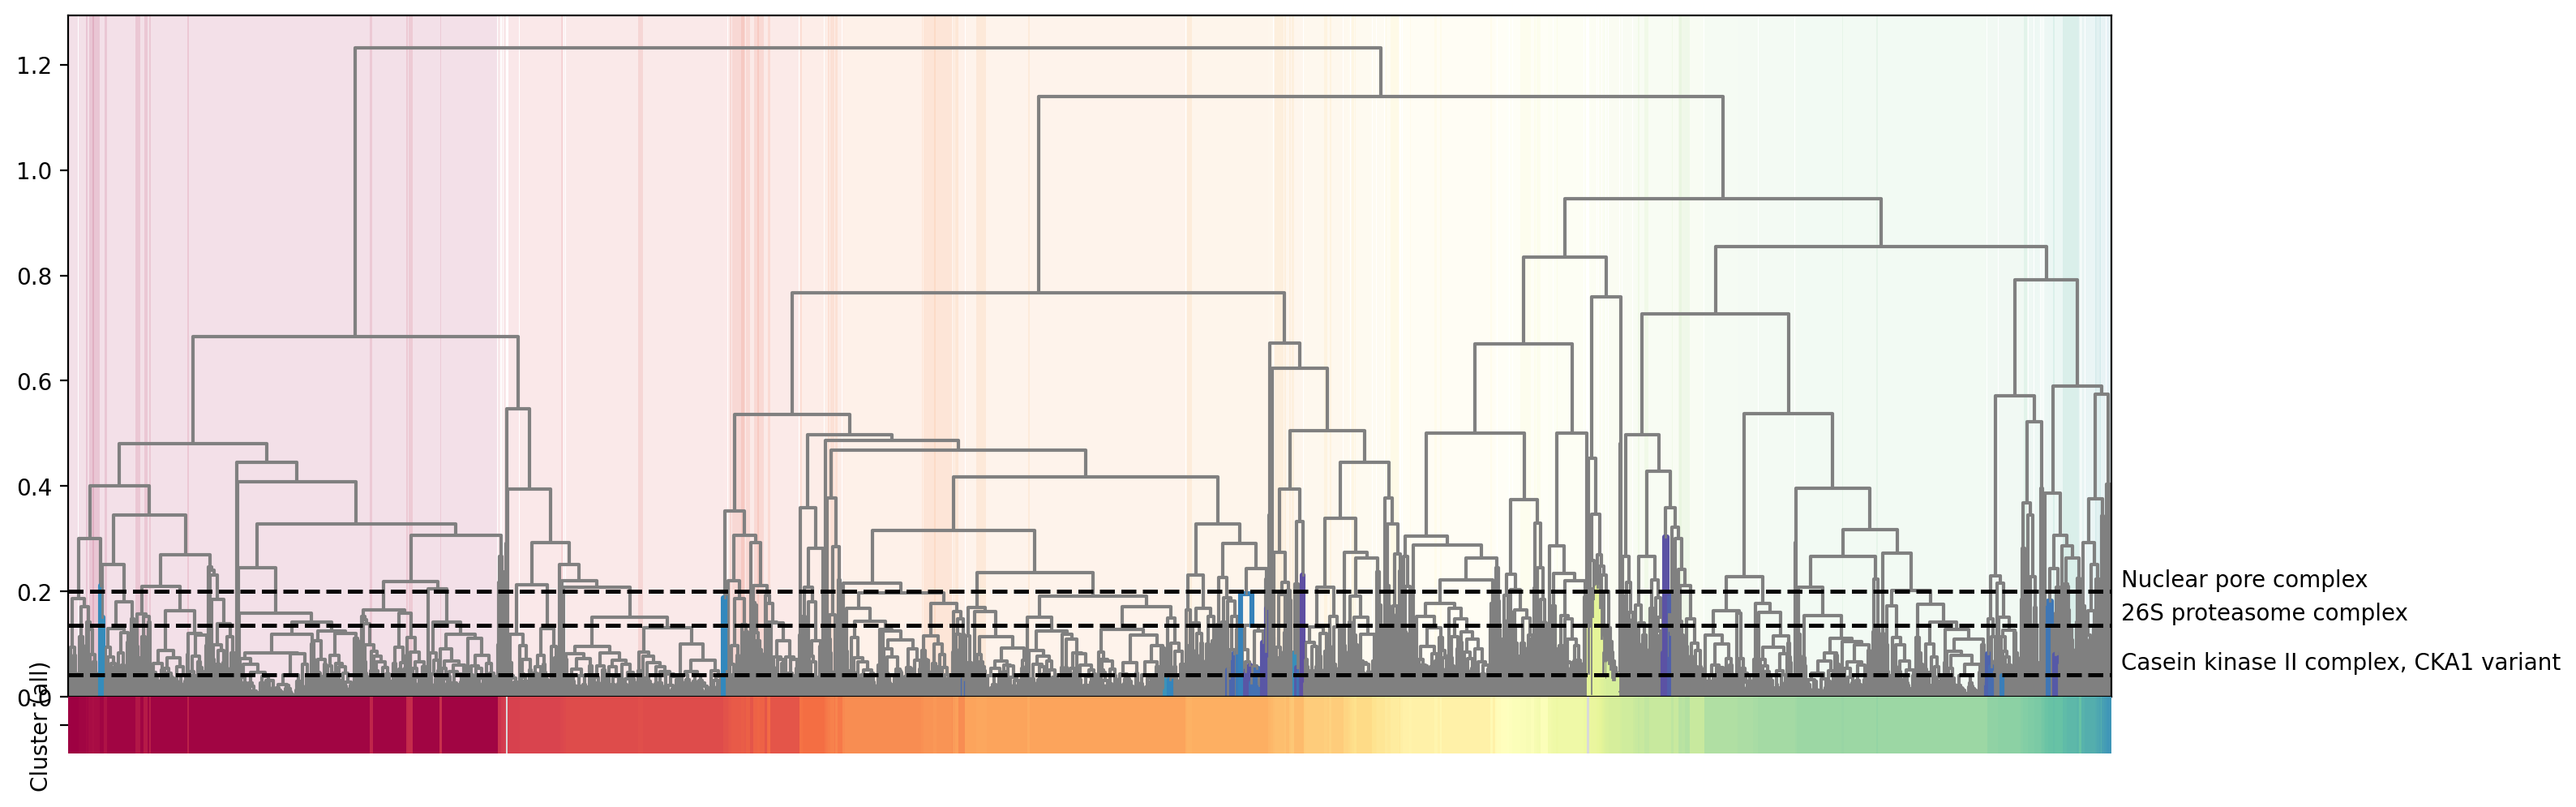

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.cluster.hierarchy import dendrogram, to_tree
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

# ----------------------------
# 1) Build mappings
# ----------------------------
cluster_id_map_all = dict(zip(eval_canon_annot['cluster_id'], eval_canon_annot['members']))
strain_to_cluster_all = {s: cid for cid, members in cluster_id_map_all.items() for s in members}

cluster_id_map_high = dict(zip(ranked_young['cluster_id'], ranked_young['members']))
strain_to_cluster_high = {s: cid for cid, members in cluster_id_map_high.items() for s in members}

# Map cluster_id → best_complex name(s)
cluster_to_complex = (
    ranked_young.groupby("cluster_id")["best_complex"]
    .apply(lambda x: ", ".join(map(str, x.unique())))
    .to_dict()
)

# ----------------------------
# 2) Dendrogram
# ----------------------------
fig = plt.figure(figsize=(14, 7))
ax_dendro = fig.add_axes([0.05, 0.35, 0.9, 0.6])

ddata = dendrogram(
    Z,
    labels=dist.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
    above_threshold_color="grey",
    color_threshold=0,
    ax=ax_dendro
)
ax_dendro.set_xticklabels([])

ivl = ddata['ivl']
x_coords = ax_dendro.get_xticks()

# ----------------------------
# 3) One consistent color map
# ----------------------------
cluster_ids_in_order = [strain_to_cluster_all.get(s, -1) for s in ivl]
ordered_clusters = []
for cid in cluster_ids_in_order:
    if cid != -1 and cid not in ordered_clusters:
        ordered_clusters.append(cid)
extra_hc = [cid for cid in set(strain_to_cluster_high.values()) if cid not in ordered_clusters]
all_clusters_order = ordered_clusters + sorted(extra_hc)

cmap_seq = cm.get_cmap("Spectral", len(all_clusters_order))
cluster_colors = {cid: cmap_seq(i) for i, cid in enumerate(all_clusters_order)}

# ----------------------------
# 4) Background bands
# ----------------------------
cluster_ranges = {}
for strain, x in zip(ivl, x_coords):
    cid = strain_to_cluster_all.get(strain, None)
    if cid is not None:
        cluster_ranges.setdefault(cid, [x, x])
        cluster_ranges[cid][0] = min(cluster_ranges[cid][0], x)
        cluster_ranges[cid][1] = max(cluster_ranges[cid][1], x)

ymin, ymax = ax_dendro.get_ylim()
for cid, (xmin, xmax) in cluster_ranges.items():
    ax_dendro.axvspan(
        xmin - 0.5, xmax + 0.5, ymin, ymax,
        facecolor=cluster_colors.get(cid, (0.8, 0.8, 0.8, 1.0)),
        alpha=0.12, zorder=0
    )

# ----------------------------
# 5) Color dendrogram branches (HIGH-CONFIDENCE only)
# ----------------------------
icoord, dcoord = ddata['icoord'], ddata['dcoord']
leaf_to_cluster_hc = {i: strain_to_cluster_high[s] for i, s in enumerate(ivl) if s in strain_to_cluster_high}

for xs, ys in zip(icoord, dcoord):
    x_leaves = [round(x/10) for x in xs if x % 10 == 5]
    clusters_here = {leaf_to_cluster_hc[i] for i in x_leaves if i in leaf_to_cluster_hc}
    if len(clusters_here) == 1:
        cid = next(iter(clusters_here))
        ax_dendro.plot(xs, ys, color=cluster_colors.get(cid, "grey"), lw=2.2)
    else:
        ax_dendro.plot(xs, ys, color="grey", lw=1.0)

# ----------------------------
# 6) Heatmap (ALL strains)
# ----------------------------
cluster_ids_all = [strain_to_cluster_all.get(s, -1) for s in ivl]
indices = [
    all_clusters_order.index(cid) if cid in all_clusters_order else len(all_clusters_order)
    for cid in cluster_ids_all
]
heatmap_data = np.array([indices])
heatmap_colors = [cluster_colors[cid] for cid in all_clusters_order] + [(0.85, 0.85, 0.85, 1.0)]
cmap = ListedColormap(heatmap_colors)
bounds = np.arange(-0.5, len(heatmap_colors) + 0.5, 1)
norm = BoundaryNorm(bounds, len(heatmap_colors))

ax_heat = fig.add_axes([0.05, 0.30, 0.9, 0.05])
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    norm=norm,
    cbar=False,
    xticklabels=False,
    yticklabels=["Cluster (all)"],
    ax=ax_heat
)
ax_heat.set_xticks([])

# ----------------------------
# 7) Exact horizontal lines + Legend
# ----------------------------
from scipy.cluster.hierarchy import to_tree

label_to_leaf_id = {label: i for i, label in enumerate(dist.index.tolist())}
root, _ = to_tree(Z, rd=True)

def find_lca(node, targets_set):
    if node.is_leaf():
        return node if node.id in targets_set else None
    left = find_lca(node.left, targets_set)
    right = find_lca(node.right, targets_set)
    if left and right:
        return node
    return left or right

target_clusters = [64, 219, 388]
legend_handles = []

for cid in target_clusters:
    members = cluster_id_map_all.get(cid, []) or cluster_id_map_high.get(cid, [])
    leaf_ids = [label_to_leaf_id[s] for s in members if s in label_to_leaf_id]
    if len(leaf_ids) < 2:
        continue
    lca_node = find_lca(root, set(leaf_ids))
    if lca_node is None:
        continue
    y = float(lca_node.dist)
    color = cluster_colors.get(cid, "black")

    ax_dendro.axhline(y=y, color='black', linestyle="--", lw=1.8, zorder=5)
    xmax = ax_dendro.get_xlim()[1]
    name = cluster_to_complex.get(cid, f"Cluster {cid}")
    ax_dendro.text(xmax+150, y, name, color='black', va="bottom", ha='left')

plt.savefig(os.path.join(out_dir, "dendrogram_clusters.pdf"), format="pdf", bbox_inches="tight")
plt.show()


In [19]:
eval_canon_selected = eval_canon_annot[eval_canon_annot['F1_complex_ppi']>0.3]
import numpy as np
import pandas as pd

# ---------------------------
# Ranking helper (drop-in)
# ---------------------------
def _nan0(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else 0.0
    except Exception:
        return 0.0

def _sig_to_score(q, cap_log10=10.0):
    """Convert q-value to [0,1] via -log10 scaling, capped."""
    q = float(q) if (q is not None and np.isfinite(q)) else 1.0
    # avoid log10(0); treat ultra-small as cap
    if q <= 0:
        return 1.0
    s = max(-np.log10(q), 0.0)
    return min(s, cap_log10) / cap_log10

def _enrich_to_score(r, cap_ratio=8.0):
    """Convert enrichment ratio to [0,1] using log2, cap at 'cap_ratio'."""
    r = float(r) if (r is not None and np.isfinite(r)) else 0.0
    if r <= 1.0:
        return 0.0
    num = min(np.log2(r), np.log2(cap_ratio))
    den = max(np.log2(cap_ratio), 1e-6)
    return float(num / den)

def _clip01(x):
    try:
        return float(np.clip(x, 0.0, 1.0))
    except Exception:
        return 0.0

def _tier(TP, FP, FN):
    if TP > 0 and FP == 0 and FN == 0:
        return "A_exact"
    if TP > 0 and FP == 0 and FN > 0:
        return "B_pure_subset"        # all members from same complex, missing some members
    if TP > 0 and FN == 0 and FP > 0:
        return "C_superset"           # full complex present, plus extras
    if TP > 0:
        return "D_partial_overlap"    # overlap but both FP and FN > 0
    return "E_no_complex"

def rank_clusters(df: pd.DataFrame, respect_tiers: bool = True):
    d = df.copy()

    # Make sure numeric columns exist and are numeric
    for col in ["size","TP","FP","FN","F1","FE","qval_complex","ppi_enrich",
                "ppi_density","qval_ppi","frac_nodes_with_ppi","margin","persist_steps"]:
        if col not in d.columns:
            d[col] = np.nan
        d[col] = pd.to_numeric(d[col], errors="coerce")

    # Derived bits
    d["M_complex_size"] = d["TP"].fillna(0) + d["FN"].fillna(0)
    d["precision"] = pd.to_numeric(d.get("precision", np.nan), errors="coerce")
    d["recall"]    = pd.to_numeric(d.get("recall",    np.nan), errors="coerce")

    # Tier labels
    d["tier"] = [_tier(int(_nan0(TP)), int(_nan0(FP)), int(_nan0(FN)))
                 for TP, FP, FN in zip(d["TP"], d["FP"], d["FN"])]

    # Component scores (all in [0,1])
    d["complex_f1_score"]   = d["F1"].apply(_clip01)  # primary "how well it forms the complex"
    d["complex_fe_score"]   = d["FE"].apply(_enrich_to_score)  # fold-enrichment support
    d["complex_q_score"]    = d["qval_complex"].apply(_sig_to_score)  # significance support

    d["ppi_enrich_score"]   = d["ppi_enrich"].apply(_enrich_to_score)
    d["ppi_q_score"]        = d["qval_ppi"].apply(_sig_to_score)
    d["ppi_density_score"]  = d["ppi_density"].apply(_clip01)
    d["ppi_nodes_score"]    = d["frac_nodes_with_ppi"].apply(_clip01)

    # Morphology margin (rough tie-break; map ~[-1,1+] -> [0,1], clip)
    d["margin_score"] = ((d["margin"].fillna(0.0) + 1.0) / 2.0).clip(0, 1)

    # Persistence (cap at 5 to avoid over-weighting)
    d["persist_score"] = (d["persist_steps"].fillna(0).clip(lower=0, upper=5) / 5.0)

    # Unexplained fraction penalty (more unexplained -> lower score)
    unexpl = d.get("n_members_unexplained", pd.Series([np.nan]*len(d)))
    size   = d["size"].replace(0, np.nan)
    d["unexplained_frac"] = (unexpl.astype(float) / size).fillna(0.0).clip(0, 1)
    d["fp_frac"]          = (d["FP"].astype(float) / size).fillna(0.0).clip(0, 1)

    # Bonuses for tier
    d["bonus_exact"]       = (d["tier"] == "A_exact").astype(float) * 0.20
    d["bonus_pure_subset"] = (d["tier"] == "B_pure_subset").astype(float) * 0.05
    d["bonus_superset"]    = (d["tier"] == "C_superset").astype(float) * 0.05

    # Combine into two main pillars
    # (weights tuned to prioritize complex formation first, then PPI strength)
    d["complex_score"] = (
        0.60 * d["complex_f1_score"] +
        0.20 * d["complex_fe_score"] +
        0.20 * d["complex_q_score"] +
        d["bonus_exact"] + d["bonus_pure_subset"] + d["bonus_superset"]
    ).clip(0, 1.5)  # can exceed 1 a bit due to bonuses

    d["ppi_score"] = (
        0.40 * d["ppi_enrich_score"] +
        0.20 * d["ppi_q_score"] +
        0.20 * d["ppi_density_score"] +
        0.20 * d["ppi_nodes_score"]
    ).clip(0, 1.0)

    # Penalties
    d["penalty"] = (
        0.60 * d["unexplained_frac"] +
        0.40 * d["fp_frac"]
    ).clip(0, 1.0)

    # Final score: complex first, then PPI; subtract penalties; add small morphology/persistence tie-breakers
    d["final_score"] = (
        0.65 * d["complex_score"] +
        0.35 * d["ppi_score"] -
        0.70 * d["penalty"] +
        0.05 * d["margin_score"] +
        0.02 * d["persist_score"]
    )

    # Optional hard tier precedence in sorting (so exact matches float to the very top)
    tier_order = {"A_exact": 0, "B_pure_subset": 1, "C_superset": 2, "D_partial_overlap": 3, "E_no_complex": 4}
    d["tier_rank"] = d["tier"].map(tier_order).fillna(5)

    sort_cols = ["tier_rank","final_score","complex_score","ppi_score","margin_score","size"]
    sort_asc  = [True, False, False, False, False, False] if respect_tiers else [False]*len(sort_cols)

    d_sorted = d.sort_values(sort_cols, ascending=sort_asc).reset_index(drop=True)
    d_sorted["rank"] = np.arange(1, len(d_sorted)+1)

    # Nice compact view of components (you can print head())
    component_cols = [
        "rank","cluster_id","tier","best_complex","size","TP","FP","FN",
        "final_score","complex_score","ppi_score","penalty",
        "F1","FE","qval_complex","ppi_enrich","qval_ppi",
        "n_members_unexplained","unexplained_frac","margin","persist_steps"
    ]
    return d_sorted, d_sorted[component_cols]


ranked_young, view_young = rank_clusters(eval_canon_selected, respect_tiers=True)

In [22]:
eval_canon_annot.to_csv(os.path.join(out_dir, "young_clusters_proteome_strain_level_3177.csv"), index=None)